Within this notebook, I simulate the quantum 
state teleportation circuit and observe the fidelity 
of the ideal circuit without noise

In [1]:
from qiskit import __version__
from qiskit_aer import __version__

print("Qiskit version: ", __version__)
print("Qiskit Aer version: ", __version__)

Qiskit version:  0.17.1
Qiskit Aer version:  0.17.1


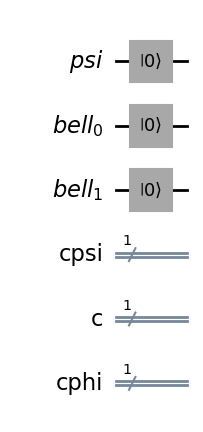

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Register qubits and classical bits
psi = QuantumRegister(1, 'psi')
cpsi = ClassicalRegister(1, 'cpsi')

bell = QuantumRegister(2, 'bell')
c = ClassicalRegister(1, 'c')
cphi = ClassicalRegister(1, 'cphi') #This will be used to read the final result

# Create a quantum circuit
qc = QuantumCircuit(psi, bell, cpsi, c, cphi)
qc.reset(psi)
qc.reset(bell)

qc.draw(output='mpl') #Needs pylatexenc, you can also just call .draw() to get a text representation

Now, we will prepare the qubit we want to send. This is done with a series of operations that end up with the configuration that you want.

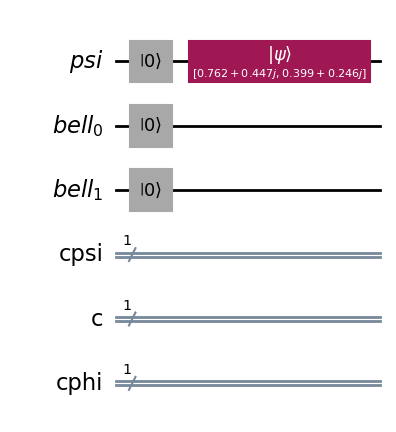

In [3]:
from qiskit.quantum_info.states.random import random_statevector
from qiskit.circuit.library import Initialize

#Generate two random complex numbers
random_vec = random_statevector(2)

#We will store the squared probabilities for future reference
probs = np.abs(random_vec)**2
probs = {0: probs[0], 1: probs[1]}

state = Initialize(random_vec)
qc.append(state, psi)

qc.draw(output='mpl')

In [4]:
#Peeking at the expected probabilities

probs

{0: np.float64(0.7803738404934162), 1: np.float64(0.21962615950658396)}

The next step is to prepare our Bell state. This will output an entangled state of two qubits. The standard way to do this is to apply a Hadamard gate to the first qubit and then a CNOT gate with the first qubit as the control and the second qubit as the target.

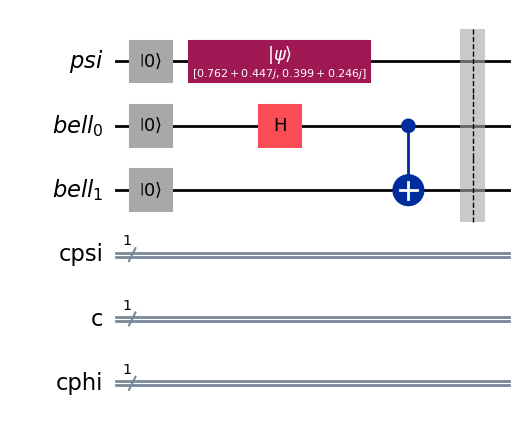

In [5]:
qc.h(bell[0])
qc.cx(bell[0], bell[1])

qc.barrier() #This is just for visualization purposes

qc.draw(output='mpl')

Now, we will entangle the qubit we want to send with the first qubit of the Bell state. This is done by applying a CNOT gate with the qubit we want to send as the control and the first qubit of the Bell state as the target and then applying a Hadamard gate to the qubit we want to send.

In [6]:
qc.cx(psi, bell[0])
qc.h(psi)

qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(1, "psi"), index=0>, <Qubit register=(2, "bell"), index=0>, <Qubit register=(2, "bell"), index=1>), clbits=())

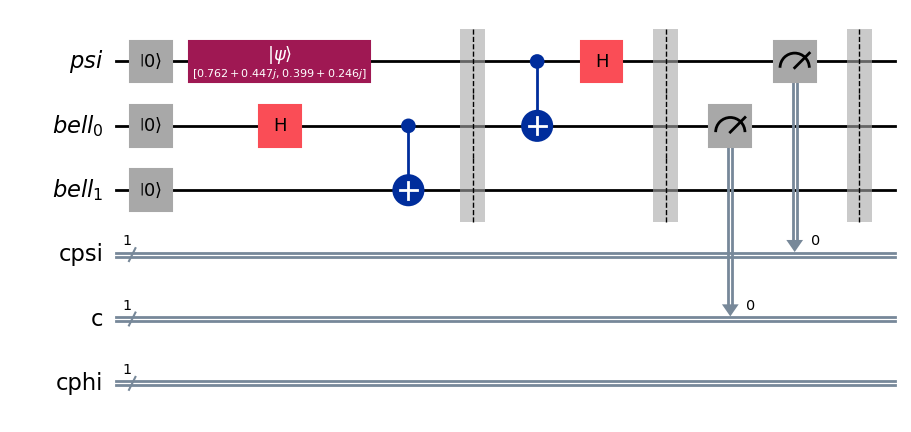

In [7]:
qc.measure(bell[0], c)
qc.measure(psi, cpsi)
qc.barrier()

qc.draw(output='mpl')

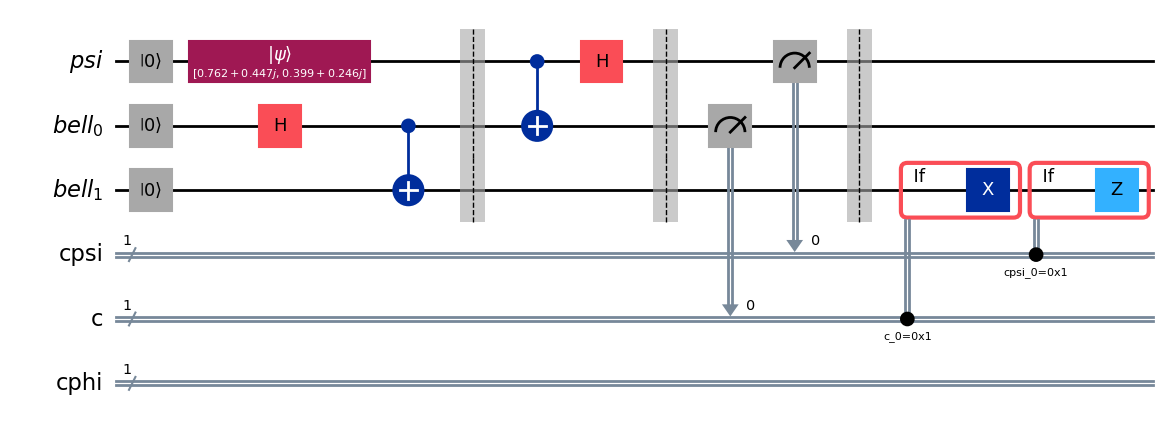

In [8]:
#Decode
# Conditional corrections — use tuple conditions, NOT comparisons
with qc.if_test((c[0], 1)):
    qc.x(2)         

with qc.if_test((cpsi[0], 1)):
    qc.z(2)

# Draw
qc.draw(output="mpl")


<Qubit register=(2, "bell"), index=1>
ClassicalRegister(1, 'cphi')


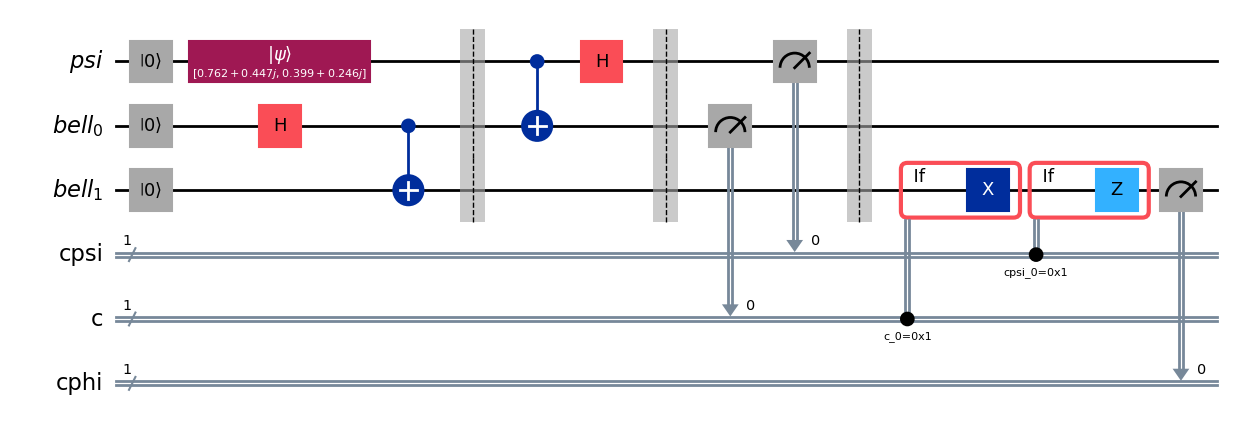

In [9]:

print(bell[1])
print(cphi)
#Measure the final state
qc.measure(bell[1], cphi)

qc.draw(output='mpl')


In [10]:
from qiskit_aer import AerSimulator

simulator = AerSimulator()
result = simulator.run(qc, shots=10000).result()

print(result.get_counts())

{'1 0 0': 535, '0 0 1': 1996, '1 1 0': 544, '0 1 0': 1882, '0 0 0': 1957, '1 0 1': 570, '1 1 1': 560, '0 1 1': 1956}


In [11]:
probs

{0: np.float64(0.7803738404934162), 1: np.float64(0.21962615950658396)}

In [12]:
from collections import Counter

receiver_counts = Counter()
receiver_counts = Counter()
for k, v in result.get_counts().items():
    receiver_counts[k[0]] += v/1000 #The order is inverted, so the first bit is the last one

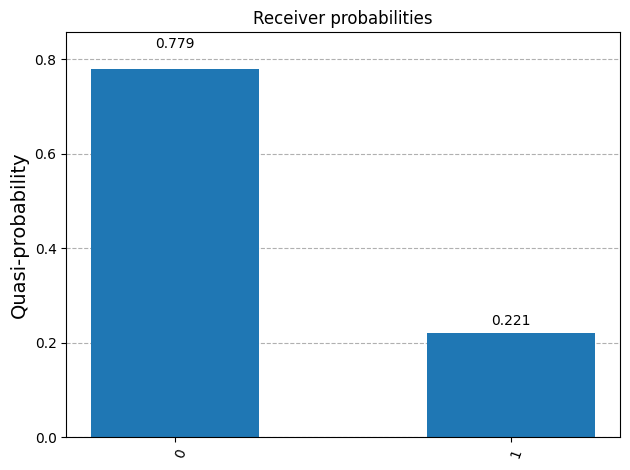

In [13]:
from qiskit.visualization import plot_histogram

plot_histogram(receiver_counts, title='Receiver probabilities')

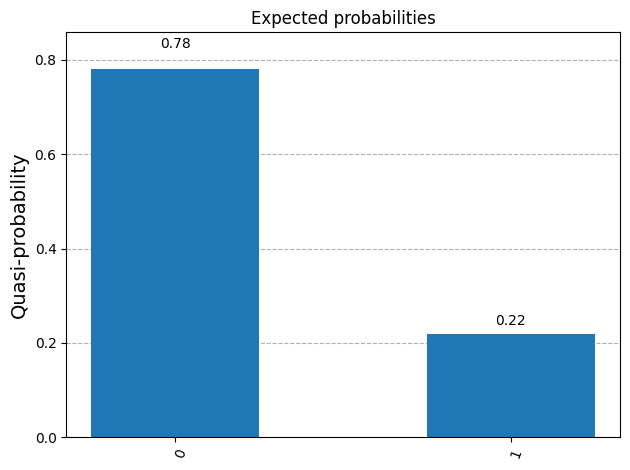

In [14]:
plot_histogram(probs, title='Expected probabilities')

In [15]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info import DensityMatrix, partial_trace

# Remove final measurements so we get the coherent state
qc_nom = qc.remove_final_measurements(inplace=False)

# Run the circuit on the density matrix simulator
sim = AerSimulator()
qc_nom.save_density_matrix()
tqc = transpile(qc_nom, sim)
res = sim.run(tqc).result()

# Full density matrix of all qubits
dm_full = DensityMatrix(res.data(0)["density_matrix"])

# Find the total number of qubits
n = qc_nom.num_qubits

# Get the index of bell[1] in the circuit
qidx = qc_nom.find_bit(bell[1]).index

# Take the partial trace over *all other qubits* to keep only bell[1]
# subsystems are numbered [0 .. n-1]; we drop everything except qidx
rho_out = partial_trace(dm_full, [i for i in range(n) if i != qidx])

print(rho_out)



DensityMatrix([[0.78037384+0.j       , 0.41389064-0.0092221j],
               [0.41389064+0.0092221j, 0.21962616+0.j       ]],
              dims=(2,))


In [16]:
import numpy as np
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity

# random_vec -> normalize & flatten to a 1D statevector
sv = np.asarray(random_vec, dtype=complex).ravel()
sv = sv / np.linalg.norm(sv)

# rho_out should be a 2×2 DensityMatrix (from your partial trace)
rho_out = DensityMatrix(rho_out)  # no-op if it already is

F = state_fidelity(Statevector(sv), rho_out)
print(f"Fidelity F(random_vec, rho_out) = {F:.6f}")


Fidelity F(random_vec, rho_out) = 1.000000
